<h1> <center>Toulouse Vs Seattle </center></h1>



<p><center>Stéphane MARTINEZ</center><p>
<p><center>April 24th 2019</center><p>


<h3> <center>Coursera Applied Data Science Capstone Assignment </center></h3>


***
***
***

## 1. Description of the problem and discussion of the background

Airbus and Boeing are the two leader of the commercial aircraft industry. Each one is sharing about 50% of the this market.   

<img src = "https://norberthaupt.files.wordpress.com/2012/04/airbusboeinggraphic.jpg" width = 800> 

Both competitors are fighting to be the One, designing and delivering the best aircraft regarding market acceptance. Aeronautics Industry is more than these two companies. A dense network of subcontractors has grown to leverage and support the industry.

<img src = "https://www.forbes.fr/wp-content/uploads/2018/02/boeing-contre-airbus-e1517822662354.jpg" width = 800>    

Boeing biggest factory is based at Seattle (USA):   
<img src = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/e3/Seattle_Kerry_Park_Skyline.jpg/1600px-Seattle_Kerry_Park_Skyline.jpg" width = 800> 


Airbus' one in Toulouse (France). 
<img src = "https://www.lepoint.fr/images/2018/08/14/16309519lpw-16309562-article-capitole-toulouse-jpg_5491231_660x281.jpg" width = 800> 

It will be interesting to compare the two cities, located on two distinct continents, to see if they have similar characteristics, and if the long distance in between can be compensated by the  major industry that live there.

In a concrete way, the two competitors need and attractive city background to retain best talents. Results from this study should also be used to discuss with the respective cities governance some action plan to improve some neighborhood services offer.


## 2. Description of the data and how it will be used to solve the problem

To consider the problem we can list the data as below:  
 - First, we can find detailed information on cities neighborhoods from wikipedia, for Seattle (https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle) and for Toulouse (https://fr.wikipedia.org/wiki/Quartiers_de_Toulouse).   
 - Then we can use GeoPy (https://geopy.readthedocs.io/en/stable/) to localize these neighborhoods.
 - The foursquare API (https://developer.foursquare.com/) can be used to gather venues informations.  
 
All these information can be processed to analyze the two cities and to see if they sharing to the same structure or not.

***
***
***


# Import libraries

In [2]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering 

import scipy
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
import scipy.cluster.hierarchy
from scipy.cluster.hierarchy import fcluster

import pylab



print('Libraries imported!')

Libraries imported!


***

# Declare functions

## Convert html table into Dataframe

This function extracts a table from a piece of html code, using BeautifulSoup:

In [3]:
def table_to_df(table):
    n_columns = 0
    n_rows=0
    column_names = []
    for row in table.find_all('tr'):
        td_tags = row.find_all('td')
        if len(td_tags) > 0:
            n_rows+=1
            if n_columns == 0:
                n_columns = len(td_tags)

        th_tags = row.find_all('th') 
        if len(th_tags) > 0 and len(column_names) == 0:
            for th in th_tags:
                column_names.append(th.get_text())

    # if len(column_names) > 0 and len(column_names) != n_columns:
        # raise Exception("Column titles do not match the number of columns")

    columns = column_names if len(column_names) > 0 else range(0,n_columns)
    df = pd.DataFrame(columns = columns,
                      index= range(0,n_rows))
    row_marker = 0
    for row in table.find_all('tr'):
        column_marker = 0
        columns = row.find_all('td')
        for column in columns:
            df.iat[row_marker,column_marker] = column.get_text()
            column_marker += 1
        if len(columns) > 0:
            row_marker += 1

    for col in df:
        try:
            df[col] = df[col].astype(float)
        except ValueError:
            pass

    return df

## Convert cell list to rows

This function allows to split a dataframe row if it contains item from a list. Each item of the list will be moved to a separated row:

In [4]:
def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    def splitListToRows(row,row_accumulator,target_column,separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df

## Find latitude and longitude from address

This function GeoPy to find latitude and longitude of a given adress:

In [5]:
def find_geo(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    try:
        location = geolocator.geocode(address)
        #print('location type :', type(location))
    
    # if type(location) == geopy.location.Location:
        latitude = location.latitude
        longitude = location.longitude
    except:
        latitude = 'None'
        longitude = 'None'
        pass
    return latitude, longitude

## Extract the category of the venue

This function extracts the category of a venue:

In [6]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## Explore Neighborhoods

This function uses foursquare's api to recover venues near and adress:

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Sort the venues in descending order

This function sorts venues in descending order:

In [8]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

***

# Load neighborhoods

In this stage, we will gather neighborhoods from wikipedia source, both for Seattle and Toulouse.

## Seattle

### Collect Seattle's neighborhoods from Wikipedia, as a list

From the Wikipedia url, the neighborhoods table is extracted, cleaned and processed to build a useful dataset

In [146]:
my_page = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle').text
soup = BeautifulSoup(my_page, 'lxml')

my_start = my_page.find("<table")
print('start :' , my_start)
my_end = my_page.find("</table>")
print('end : ', my_end)
my_table = my_page[my_start:my_end+8]
# print(my_table)

soup = BeautifulSoup(my_table, 'lxml')

table_df = table_to_df(soup)
table_df = table_df.replace('\n',' ', regex=True)
table_df = table_df.replace('\(',' /$', regex=True)
table_df = table_df.replace('\[',' /$', regex=True)
# table_df = table_df.replace("[",'B', regex=True)

table_df= table_df.rename(index=str, columns={'\n': "Neighborhood"})

table_df = splitDataFrameList(table_df,"Neighborhood",' /')
table_df = table_df[table_df.Neighborhood != '']
table_df['City'] = 'Seattle'
table_df2 = table_df[~table_df["Neighborhood"].str.get(0).isin(['$'])]



seattle_nb_df = table_df2[["Neighborhood", 'City']].reset_index()

seattle_nb_df.head(5)

start : 34233
end :  283940


,index,Neighborhood,City
0,0,North Seattle,Seattle
1,1,Broadview,Seattle
2,2,Bitter Lake,Seattle
3,3,North Beach,Seattle
4,4,Blue Ridge,Seattle


### Save Seattle neighborhoods to csv (backup)

Then, when the neighborhoods dataset is build, it is saved as a backup csv file.

In [147]:
seattle_nb_df.to_csv('seattle_nb_df.csv')

## Toulouse

### Collect Toulouse's neighborhoods from Wikipedia, as a list

From the Wikipedia url, the neighborhoods table is extracted, cleaned and processed to build a useful dataset

In [155]:
my_page = requests.get('https://fr.wikipedia.org/wiki/Quartiers_de_Toulouse').text
soup = BeautifulSoup(my_page, 'lxml')

# print(soup.prettify())

my_start = my_page.find("Le secteur 1 - Toulouse Centre")
print('start :' , my_start)
my_end = my_page.find("Auparavant la ville était divisée en 17")
print('end : ', my_end)
my_table = my_page[my_start:my_end+8]
# print(my_table)

soup = BeautifulSoup(my_table, 'lxml')

table_df = table_to_df(soup)
table_df.columns

table_df= table_df.rename(index=str, columns={'Quartiers historiques\n': "Neighborhood"})
table_df = table_df[["Neighborhood"]]
table_df = splitDataFrameList(table_df,"Neighborhood",'\n')
table_df = table_df[toulouse_nb_df2.Neighborhood != ''].reset_index()
table_df['City'] = 'Toulouse'
# toulouse_nb_df.head(12)

toulouse_nb_df = table_df[["Neighborhood", 'City']]
toulouse_nb_df.head(5)

start : 17191
end :  34631


,Neighborhood,City
0,Capitole,Toulouse
1,Les Carmes,Toulouse
2,Arnaud Bernard,Toulouse
3,Saint-Georges,Toulouse
4,Saint-Étienne,Toulouse


### Save Toulouse neighborhoods to csv (backup)

Then, when the neighborhoods dataset is build, it is saved as a backup csv file.

In [156]:
toulouse_nb_df.to_csv('toulouse_nb_df.csv')

***
***

# Neighborhoods geolocalization

In this stage, we will use GeoPy to get localisation for each Neighborhood.

## Seattle Neighborhoods

First, we create the latitude and longitude columns to be filled, and concatenate the Neighborhood with the City's name.

In [241]:
seattle_nb_geo_df = seattle_nb_df[["Neighborhood", 'City']]
seattle_nb_geo_df["lat"] = 'None'
seattle_nb_geo_df["lon"] = 'None'
seattle_nb_geo_df["address"] = seattle_nb_geo_df["Neighborhood"] + ', ' + seattle_nb_geo_df["City"]

seattle_nb_geo_df.head()

,Neighborhood,City,lat,lon,address
0,North Seattle,Seattle,None,None,"North Seattle , Seattle"
1,Broadview,Seattle,None,None,"Broadview , Seattle"
2,Bitter Lake,Seattle,None,None,"Bitter Lake , Seattle"
3,North Beach,Seattle,None,None,"North Beach, Seattle"
4,Blue Ridge,Seattle,None,None,"Blue Ridge , Seattle"


The following for loop allows to populate latitude and longitude.

In [242]:
for index, row in seattle_nb_geo_df.iterrows():
    row['lat'] , row['lon'] = find_geo(row['address'])
    # print (row)

Then the dataset is filtered to discard non geolocalized data.

In [248]:
seattle_nb_geo_filtered_df = seattle_nb_geo_df[seattle_nb_geo_df.lat != 'None'].reset_index()
seattle_nb_geo_filtered_df.head()

,index,Neighborhood,City,lat,lon,address
0,0,North Seattle,Seattle,47.6608,-122.291,"North Seattle , Seattle"
1,1,Broadview,Seattle,47.7223,-122.36,"Broadview , Seattle"
2,2,Bitter Lake,Seattle,47.7266,-122.352,"Bitter Lake , Seattle"
3,3,North Beach,Seattle,47.6962,-122.392,"North Beach, Seattle"
4,4,Blue Ridge,Seattle,47.7015,-122.375,"Blue Ridge , Seattle"


## Save Seattle neighborhoods localizations to csv (backup)

Finally, the geolocalized neighborhood dataset is saved as csv backup file.

In [249]:
seattle_nb_geo_filtered_df.to_csv('seattle_nb_geo_filtered_df.csv')

## Toulouse Neighborhoods

First, we create the latitude and longitude columns to be filled, and concatenate the Neighborhood with the City's name.

In [250]:
toulouse_nb_geo_df = toulouse_nb_df[["Neighborhood", 'City']]
toulouse_nb_geo_df["lat"] = 'None'
toulouse_nb_geo_df["lon"] = 'None'
toulouse_nb_geo_df["address"] = toulouse_nb_geo_df["Neighborhood"] + ', ' + toulouse_nb_geo_df["City"]

toulouse_nb_geo_df.head()

,Neighborhood,City,lat,lon,address
0,Capitole,Toulouse,None,None,"Capitole, Toulouse"
1,Les Carmes,Toulouse,None,None,"Les Carmes, Toulouse"
2,Arnaud Bernard,Toulouse,None,None,"Arnaud Bernard, Toulouse"
3,Saint-Georges,Toulouse,None,None,"Saint-Georges, Toulouse"
4,Saint-Étienne,Toulouse,None,None,"Saint-Étienne, Toulouse"


The following for loop allows to populate latitude and longitude.

In [251]:
for index, row in toulouse_nb_geo_df.iterrows():
    row['lat'] , row['lon'] = find_geo(row['address'])

Then the dataset is filtered to discard non geolocalized data.

In [252]:
toulouse_nb_geo_filtered_df = toulouse_nb_geo_df[toulouse_nb_geo_df.lat != 'None'].reset_index()
toulouse_nb_geo_filtered_df.head()

,index,Neighborhood,City,lat,lon,address
0,0,Capitole,Toulouse,43.6044,1.44449,"Capitole, Toulouse"
1,1,Les Carmes,Toulouse,43.598,1.44429,"Les Carmes, Toulouse"
2,2,Arnaud Bernard,Toulouse,43.6105,1.43935,"Arnaud Bernard, Toulouse"
3,3,Saint-Georges,Toulouse,43.6033,1.45151,"Saint-Georges, Toulouse"
4,4,Saint-Étienne,Toulouse,43.6,1.44915,"Saint-Étienne, Toulouse"


### Save Toulouse neighborhoods localizations to csv (backup)

Finally, the geolocalized neighborhood dataset is saved as csv backup file.

In [253]:
toulouse_nb_geo_filtered_df.to_csv('toulouse_nb_geo_filtered_df.csv')

***
***

# Visualize neighborhoods in a map (without clustering)

## Recover data from csv backup files

### Seattle

In [9]:
# Seattle
filename_seattle = 'seattle_nb_geo_filtered_df.csv'

#Read csv
seattle_nb_geo_filtered_df = pd.read_csv(filename_seattle)[["Neighborhood", 'City', 'lat', 'lon', 'address']]
print ("Shape of Seattle dataset: ", seattle_nb_geo_filtered_df.shape)
seattle_nb_geo_filtered_df.head(5)

Shape of Seattle dataset:  (132, 5)


,Neighborhood,City,lat,lon,address
0,North Seattle,Seattle,47.660773,-122.291497,"North Seattle , Seattle"
1,Broadview,Seattle,47.722320,-122.360407,"Broadview , Seattle"
2,Bitter Lake,Seattle,47.726645,-122.352272,"Bitter Lake , Seattle"
3,North Beach,Seattle,47.696210,-122.392362,"North Beach, Seattle"
4,Blue Ridge,Seattle,47.701487,-122.375407,"Blue Ridge , Seattle"


### Toulouse

In [10]:
# Toulouse
filename_toulouse = 'toulouse_nb_geo_filtered_df.csv'

#Read csv
toulouse_nb_geo_filtered_df = pd.read_csv(filename_toulouse)[["Neighborhood", 'City', 'lat', 'lon', 'address']]
print ("Shape of Toulouse dataset: ", toulouse_nb_geo_filtered_df.shape)
toulouse_nb_geo_filtered_df.head(5)

Shape of Toulouse dataset:  (62, 5)


,Neighborhood,City,lat,lon,address
0,Capitole,Toulouse,43.604450,1.444494,"Capitole, Toulouse"
1,Les Carmes,Toulouse,43.597990,1.444286,"Les Carmes, Toulouse"
2,Arnaud Bernard,Toulouse,43.610512,1.439345,"Arnaud Bernard, Toulouse"
3,Saint-Georges,Toulouse,43.603305,1.451512,"Saint-Georges, Toulouse"
4,Saint-Étienne,Toulouse,43.599985,1.449151,"Saint-Étienne, Toulouse"


## Plot Neighborhoods (without clustering)

### Seattle

In [11]:
address = 'Seattle'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Seattle are 47.6038321, -122.3300624.


In [12]:
# create map of Seattle using latitude and longitude values
map_seattle = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(seattle_nb_geo_filtered_df['lat'], seattle_nb_geo_filtered_df['lon'], seattle_nb_geo_filtered_df['City'], seattle_nb_geo_filtered_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seattle)  
    
map_seattle

### Toulouse

In [13]:
address = 'Toulouse'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Toulouse are 43.6044622, 1.4442469.


In [14]:
# create map of Toulouse using latitude and longitude values
map_toulouse = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toulouse_nb_geo_filtered_df['lat'], toulouse_nb_geo_filtered_df['lon'], toulouse_nb_geo_filtered_df['City'], toulouse_nb_geo_filtered_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toulouse)  
    
map_toulouse

***
***

# Merge Seattle and Toulouse Neighborhoods Datasets

In this stage, we will merge geolocalized neighborhood datasets for Toulouse and Seattle to allow unique processing, including clustering.

In [29]:
neighborhoods_df = pd.concat([toulouse_nb_geo_filtered_df, seattle_nb_geo_filtered_df])
print('Shape: ', neighborhoods_df.shape)
neighborhoods_df.head(5)

Shape:  (194, 5)


,Neighborhood,City,lat,lon,address
0,Capitole,Toulouse,43.604450,1.444494,"Capitole, Toulouse"
1,Les Carmes,Toulouse,43.597990,1.444286,"Les Carmes, Toulouse"
2,Arnaud Bernard,Toulouse,43.610512,1.439345,"Arnaud Bernard, Toulouse"
3,Saint-Georges,Toulouse,43.603305,1.451512,"Saint-Georges, Toulouse"
4,Saint-Étienne,Toulouse,43.599985,1.449151,"Saint-Étienne, Toulouse"


***
***

# Recover neighborhoods venues from Foursquare's API

In this stage, we will gather venues information for both Seattle and Toulouse neighborhoods

## Define Foursquare Credentials and Version

In [16]:
CLIENT_ID = 'anonymized' # your Foursquare ID
CLIENT_SECRET = 'anonymized' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: anonymized
CLIENT_SECRET:anonymized


## Gather venues

In [12]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

seattle_and_toulouse_venues = getNearbyVenues(names=neighborhoods_df['address'],
                                   latitudes=neighborhoods_df['lat'],
                                   longitudes=neighborhoods_df['lon']
                                  )


Capitole, Toulouse
Les Carmes, Toulouse
Arnaud Bernard, Toulouse
Saint-Georges, Toulouse
Saint-Étienne, Toulouse
Les Amidonniers, Toulouse
Compans-Caffarelli, Toulouse
Les Chalets, Toulouse
Matabiau, Toulouse
Fer à Cheval, Toulouse
Patte d'Oie, Toulouse
Saint-Cyprien, Toulouse
Croix de Pierre, Toulouse
Route d'Espagne, Toulouse
Arènes, Toulouse
Bagatelle, Toulouse
Fontaine-Lestang, Toulouse
La Faourette, Toulouse
Mermoz, Toulouse
Papus, Toulouse
Casselardit, Toulouse
La Cépière, Toulouse
Barrière-de-Paris, Toulouse
Minimes, Toulouse
Ginestous, Toulouse
Lalande, Toulouse
Sept Deniers, Toulouse
Croix-Daurade, Toulouse
Bonnefoy, Toulouse
Marengo-Jolimont, Toulouse
Gramont, Toulouse
Roseraie, Toulouse
Soupetard, Toulouse
Côte Pavée, Toulouse
Château de l'Hers, Toulouse
Guilheméry, Toulouse
La Terrasse, Toulouse
Pont des Demoiselles, Toulouse
Montaudran, Toulouse
La Terrasse, Toulouse
L'Ormeau, Toulouse
Malepère, Toulouse
Rangueil, Toulouse
Sauzelong, Toulouse
Pech-David, Toulouse
Pouvourvi

## Visualize venues' dataset

Lets have a look at the venues

In [13]:
print(seattle_and_toulouse_venues.shape)
seattle_and_toulouse_venues.head()

(4630, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Capitole, Toulouse",43.60445,1.444494,Place du Capitole,43.604386,1.443404,Plaza
1,"Capitole, Toulouse",43.60445,1.444494,Winter Garden,43.603061,1.442378,Restaurant
2,"Capitole, Toulouse",43.60445,1.444494,Ô Thé Divin,43.602976,1.444099,Tea Room
3,"Capitole, Toulouse",43.60445,1.444494,Amorino,43.604749,1.442801,Ice Cream Shop
4,"Capitole, Toulouse",43.60445,1.444494,Ombres Blanches,43.603146,1.442515,Bookstore


## Save venues to csv (backup)

Now, save venues dataset to a csv backup file.

In [14]:
seattle_and_toulouse_venues.to_csv('seattle_and_toulouse_venues.csv')

***
***

# Venues pre processing

In this stage, we will prepare data for clustering process

### Recover data from csv backup file

In [19]:
# Seattle
filename_venues = 'seattle_and_toulouse_venues.csv'

#Read csv
seattle_and_toulouse_venues_df = pd.read_csv(filename_venues)
print ("Shape of Venues dataset: ", seattle_and_toulouse_venues_df.shape)
seattle_and_toulouse_venues_df.head(5)

Shape of Venues dataset:  (4630, 8)


,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,"Capitole, Toulouse",43.60445,1.444494,Place du Capitole,43.604386,1.443404,Plaza
1,1,"Capitole, Toulouse",43.60445,1.444494,Winter Garden,43.603061,1.442378,Restaurant
2,2,"Capitole, Toulouse",43.60445,1.444494,Ô Thé Divin,43.602976,1.444099,Tea Room
3,3,"Capitole, Toulouse",43.60445,1.444494,Amorino,43.604749,1.442801,Ice Cream Shop
4,4,"Capitole, Toulouse",43.60445,1.444494,Ombres Blanches,43.603146,1.442515,Bookstore


Let's check how many venues were returned for each neighborhood

In [20]:
seattle_and_toulouse_venues_df.groupby('Neighborhood').count()

,Unnamed: 0,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
"Alaska Junction , Seattle",49,49,49,49,49,49,49
"Blue Ridge , Seattle",4,4,4,4,4,4,4
"Central District , Seattle",17,17,17,17,17,17,17
"Denny-Blaine, Seattle",6,6,6,6,6,6,6
"Lakeridge , Seattle",4,4,4,4,4,4,4
"NewHolly, Seattle",4,4,4,4,4,4,4
"Othello , Seattle",13,13,13,13,13,13,13
"Pike/Pine, Seattle",100,100,100,100,100,100,100
"Roanoke , Seattle",20,20,20,20,20,20,20


Let's find out how many unique categories can be curated from all the returned venues

In [21]:
print('There are {} uniques categories.'.format(len(seattle_and_toulouse_venues_df['Venue Category'].unique())))

There are 338 uniques categories.


Analyze Each Neighborhood

In [22]:
# one hot encoding
seattle_and_toulouse_onehot = pd.get_dummies(seattle_and_toulouse_venues_df[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
seattle_and_toulouse_onehot['Neighborhood'] = seattle_and_toulouse_venues_df['Neighborhood'] 

# get a list of columns
cols = list(seattle_and_toulouse_onehot)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('Neighborhood')))
# use ix to reorder
seattle_and_toulouse_onehot = seattle_and_toulouse_onehot.loc[:, cols]
seattle_and_toulouse_onehot.head()

,Neighborhood,ATM,Accessories Store,African Restaurant,Airport Terminal,Alternative Healer,American Restaurant,Antique Shop,Aquarium,Arcade,...,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"Capitole, Toulouse",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Capitole, Toulouse",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Capitole, Toulouse",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Capitole, Toulouse",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Capitole, Toulouse",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [23]:
seattle_and_toulouse_grouped = seattle_and_toulouse_onehot.groupby('Neighborhood').mean().reset_index()
seattle_and_toulouse_grouped.head(12)

,Neighborhood,ATM,Accessories Store,African Restaurant,Airport Terminal,Alternative Healer,American Restaurant,Antique Shop,Aquarium,Arcade,...,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"Alaska Junction , Seattle",0.00,0.0,0.0,0.00,0.0,0.020408,0.00,0.0,0.000000,...,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.020408,0.0,0.0
1,"Blue Ridge , Seattle",0.00,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.000000,...,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0
2,"Central District , Seattle",0.00,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.000000,...,0.058824,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0
3,"Denny-Blaine, Seattle",0.00,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.000000,...,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0
4,"Lakeridge , Seattle",0.00,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.000000,...,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0
5,"NewHolly, Seattle",0.00,0.0,0.0,0.25,0.0,0.000000,0.00,0.0,0.000000,...,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0
6,"Othello , Seattle",0.00,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.000000,...,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0
7,"Pike/Pine, Seattle",0.00,0.0,0.0,0.00,0.0,0.000000,0.01,0.0,0.000000,...,0.000000,0.0,0.0,0.01,0.0,0.0,0.0,0.010000,0.0,0.0
8,"Roanoke , Seattle",0.05,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.000000,...,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0
9,"Van Asselt , Seattle",0.00,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.030303,...,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0


Let's confirm the new size

In [24]:
seattle_and_toulouse_grouped.shape

(191, 338)

Now let's create the new dataframe and display the top 10 venues for each neighborhood

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
seattle_and_toulouse_venues_sorted = pd.DataFrame(columns=columns)
seattle_and_toulouse_venues_sorted['Neighborhood'] = seattle_and_toulouse_grouped['Neighborhood']

for ind in np.arange(seattle_and_toulouse_grouped.shape[0]):
    seattle_and_toulouse_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seattle_and_toulouse_grouped.iloc[ind, :], num_top_venues)

seattle_and_toulouse_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Alaska Junction , Seattle",Pizza Place,Coffee Shop,Spa,Asian Restaurant,Bakery,Lounge,Beer Store,Supermarket,Steakhouse,Furniture / Home Store
1,"Blue Ridge , Seattle",Dance Studio,Café,Garden Center,Pool,Zoo Exhibit,Fish Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field
2,"Central District , Seattle",Coffee Shop,Performing Arts Venue,Chinese Restaurant,Water Park,Gym,BBQ Joint,Fish & Chips Shop,Art Gallery,Vietnamese Restaurant,Ethiopian Restaurant
3,"Denny-Blaine, Seattle",Park,Monument / Landmark,Beach,Zoo Exhibit,Fish Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
4,"Lakeridge , Seattle",Park,Pizza Place,Playground,Fish & Chips Shop,Factory,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field


***
***

# Analyzing Neighborhoods using k-means clustering

## Processing k-means clustering

Run k-means to cluster the neighborhood into 5 clusters.

In [26]:
# set number of clusters
kclusters = 5

seattle_and_toulouse_grouped_clustering = seattle_and_toulouse_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seattle_and_toulouse_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 4, 1, 1, 1, 4, 4, 4, 4], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [27]:
# add clustering labels
seattle_and_toulouse_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
seattle_and_toulouse_venues_sorted.head(4)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4,"Alaska Junction , Seattle",Pizza Place,Coffee Shop,Spa,Asian Restaurant,Bakery,Lounge,Beer Store,Supermarket,Steakhouse,Furniture / Home Store
1,4,"Blue Ridge , Seattle",Dance Studio,Café,Garden Center,Pool,Zoo Exhibit,Fish Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field
2,4,"Central District , Seattle",Coffee Shop,Performing Arts Venue,Chinese Restaurant,Water Park,Gym,BBQ Joint,Fish & Chips Shop,Art Gallery,Vietnamese Restaurant,Ethiopian Restaurant
3,1,"Denny-Blaine, Seattle",Park,Monument / Landmark,Beach,Zoo Exhibit,Fish Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


In [30]:
neighborhoods_df.head(4)

,Neighborhood,City,lat,lon,address
0,Capitole,Toulouse,43.604450,1.444494,"Capitole, Toulouse"
1,Les Carmes,Toulouse,43.597990,1.444286,"Les Carmes, Toulouse"
2,Arnaud Bernard,Toulouse,43.610512,1.439345,"Arnaud Bernard, Toulouse"
3,Saint-Georges,Toulouse,43.603305,1.451512,"Saint-Georges, Toulouse"


In [31]:
# merge datasets to add latitude/longitude for each neighborhood
seattle_and_toulouse_merged = neighborhoods_df.join(seattle_and_toulouse_venues_sorted.set_index('Neighborhood'), on='address')
seattle_and_toulouse_merged.head(4) 

,Neighborhood,City,lat,lon,address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Capitole,Toulouse,43.604450,1.444494,"Capitole, Toulouse",4.0,French Restaurant,Plaza,Tea Room,Bar,Ice Cream Shop,Coffee Shop,Hotel,Restaurant,Bookstore,Wine Bar
1,Les Carmes,Toulouse,43.597990,1.444286,"Les Carmes, Toulouse",4.0,French Restaurant,Bar,Plaza,Café,Restaurant,Wine Bar,Hotel,Tapas Restaurant,Tea Room,Dessert Shop
2,Arnaud Bernard,Toulouse,43.610512,1.439345,"Arnaud Bernard, Toulouse",4.0,French Restaurant,Bar,Café,Restaurant,Pub,Farmers Market,Sushi Restaurant,Plaza,Hotel,Movie Theater
3,Saint-Georges,Toulouse,43.603305,1.451512,"Saint-Georges, Toulouse",4.0,French Restaurant,Bar,Hotel,Plaza,Ice Cream Shop,Pizza Place,Tapas Restaurant,Pub,Wine Shop,Japanese Restaurant


## Visualized clusters

Finally, let's visualize the resulting clusters for

### Seattle

In [32]:
seattle_and_toulouse_merged2 = seattle_and_toulouse_merged[seattle_and_toulouse_merged["Cluster Labels"]>= 0].reset_index()
seattle_and_toulouse_merged2["Cluster Labels"] = seattle_and_toulouse_merged2["Cluster Labels"].astype(int)

address = 'Seattle'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

# create map
seattle_map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seattle_and_toulouse_merged2['lat'], seattle_and_toulouse_merged2['lon'], seattle_and_toulouse_merged2['address'], seattle_and_toulouse_merged2['Cluster Labels']):
    cluster = int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(seattle_map_clusters)
       
seattle_map_clusters

The geograpical coordinate of Seattle are 47.6038321, -122.3300624.


### Toulouse

In [33]:
address = 'Toulouse'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

# create map
toulouse_map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seattle_and_toulouse_merged2['lat'], seattle_and_toulouse_merged2['lon'], seattle_and_toulouse_merged2['address'], seattle_and_toulouse_merged2['Cluster Labels']):
    cluster = int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(toulouse_map_clusters)
       
toulouse_map_clusters

The geograpical coordinate of Toulouse are 43.6044622, 1.4442469.


***
***

# Deep Dive into k-means Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

### Cluster 1

In [63]:
seattle_and_toulouse_merged2.loc[seattle_and_toulouse_merged2['Cluster Labels'] == 0, seattle_and_toulouse_merged2.columns[[1] + list(range(5, seattle_and_toulouse_merged2.shape[1]))]]

,Neighborhood,address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Ginestous,"Ginestous, Toulouse",0,Camera Store,Business Service,Zoo Exhibit,Fish & Chips Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
45,Pouvourville,"Pouvourville, Toulouse",0,Business Service,Bakery,Athletics & Sports,Zoo Exhibit,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
59,Lafourguette,"Lafourguette, Toulouse",0,Auto Workshop,Sporting Goods Shop,Grocery Store,Business Service,Zoo Exhibit,Fish & Chips Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field
77,Victory Heights,"Victory Heights , Seattle",0,Garden,Business Service,Zoo Exhibit,Fish Market,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


### Cluster 2

In [64]:
seattle_and_toulouse_merged2.loc[seattle_and_toulouse_merged2['Cluster Labels'] == 1, seattle_and_toulouse_merged2.columns[[1] + list(range(5, seattle_and_toulouse_merged2.shape[1]))]]

,Neighborhood,address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Pech-David,"Pech-David, Toulouse",1,Park,Rugby Pitch,Scenic Lookout,Zoo Exhibit,Filipino Restaurant,Factory,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant
64,North Beach,"North Beach, Seattle",1,Beach,Park,Zoo Exhibit,Fish Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
73,Cedar Park,"Cedar Park , Seattle",1,Vietnamese Restaurant,Park,Supermarket,Zoo Exhibit,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
74,Matthews Beach,"Matthews Beach , Seattle",1,Park,Playground,Trail,Zoo Exhibit,Fish & Chips Shop,Factory,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant
79,View Ridge,"View Ridge , Seattle",1,Park,Construction & Landscaping,Zoo Exhibit,Fish Market,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
101,Magnolia,"Magnolia , Seattle",1,Park,Bus Stop,Gym / Fitness Center,Korean Restaurant,Garden,Dog Run,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant
103,Briarcliff,"Briarcliff , Seattle",1,Bus Stop,Trail,Park,Athletics & Sports,Eye Doctor,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field
104,Southeast Magnolia,"Southeast Magnolia , Seattle",1,Park,Bus Stop,Gym / Fitness Center,Korean Restaurant,Garden,Dog Run,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant
118,Interlaken,"Interlaken , Seattle",1,Park,Scenic Lookout,Playground,Zoo Exhibit,Factory,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field
143,Judkins Park,"Judkins Park , Seattle",1,Park,Dog Run,Skate Park,Tunnel,Bus Stop,Trail,Museum,Food,Fast Food Restaurant,Factory


### Cluster 3

In [65]:
seattle_and_toulouse_merged2.loc[seattle_and_toulouse_merged2['Cluster Labels'] == 2, seattle_and_toulouse_merged2.columns[[1] + list(range(5, seattle_and_toulouse_merged2.shape[1]))]]

,Neighborhood,address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,La Cépière,"La Cépière, Toulouse",2,Hotel,Grocery Store,Zoo Exhibit,Fish & Chips Shop,Factory,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field
36,La Terrasse,"La Terrasse, Toulouse",2,Hotel,Pizza Place,Zoo Exhibit,Factory,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
39,La Terrasse,"La Terrasse, Toulouse",2,Hotel,Pizza Place,Zoo Exhibit,Factory,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
60,Oncopole,"Oncopole, Toulouse",2,Hotel,French Restaurant,Fish Market,Factory,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


### Cluster 4

In [66]:
seattle_and_toulouse_merged2.loc[seattle_and_toulouse_merged2['Cluster Labels'] == 3, seattle_and_toulouse_merged2.columns[[1] + list(range(5, seattle_and_toulouse_merged2.shape[1]))]]

,Neighborhood,address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Matabiau,"Matabiau, Toulouse",3,Hotel,French Restaurant,Nightclub,Bakery,Sandwich Place,Food,Supermarket,Thai Restaurant,Lounge,Train Station
9,Fer à Cheval,"Fer à Cheval, Toulouse",3,French Restaurant,Park,Music Venue,Tram Station,Hotel,Nightclub,Volleyball Court,Home Service,Filipino Restaurant,Fair
20,Casselardit,"Casselardit, Toulouse",3,Tram Station,Bakery,Hotel,Zoo Exhibit,Fish Market,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field
23,Minimes,"Minimes, Toulouse",3,Bakery,Other Nightlife,Hotel,Comedy Club,Metro Station,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field
28,Bonnefoy,"Bonnefoy, Toulouse",3,Hotel,French Restaurant,Nightclub,Bakery,Sandwich Place,Food,Supermarket,Thai Restaurant,Lounge,Train Station
29,Marengo-Jolimont,"Marengo-Jolimont, Toulouse",3,Hotel,French Restaurant,Bakery,Sandwich Place,Supermarket,Lounge,Pizza Place,Nightclub,Train Station,Field
30,Gramont,"Gramont, Toulouse",3,Hotel,French Restaurant,Nightclub,Bakery,Sandwich Place,Food,Supermarket,Thai Restaurant,Lounge,Train Station
31,Roseraie,"Roseraie, Toulouse",3,Hotel,French Restaurant,Nightclub,Bakery,Sandwich Place,Food,Supermarket,Thai Restaurant,Lounge,Train Station
41,Malepère,"Malepère, Toulouse",3,Furniture / Home Store,French Restaurant,Kids Store,Hotel,Asian Restaurant,Fish Market,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant
49,Arènes Romaines,"Arènes Romaines, Toulouse",3,Tram Station,Hotel,Historic Site,Zoo Exhibit,Fish & Chips Shop,Factory,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant


### Cluster 5

In [67]:
seattle_and_toulouse_merged2.loc[seattle_and_toulouse_merged2['Cluster Labels'] == 4, seattle_and_toulouse_merged2.columns[[1] + list(range(5, seattle_and_toulouse_merged2.shape[1]))]]

,Neighborhood,address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Capitole,"Capitole, Toulouse",4,French Restaurant,Plaza,Tea Room,Bar,Ice Cream Shop,Coffee Shop,Hotel,Restaurant,Bookstore,Wine Bar
1,Les Carmes,"Les Carmes, Toulouse",4,French Restaurant,Bar,Plaza,Café,Restaurant,Wine Bar,Hotel,Tapas Restaurant,Tea Room,Dessert Shop
2,Arnaud Bernard,"Arnaud Bernard, Toulouse",4,French Restaurant,Bar,Café,Restaurant,Pub,Farmers Market,Sushi Restaurant,Plaza,Hotel,Movie Theater
3,Saint-Georges,"Saint-Georges, Toulouse",4,French Restaurant,Bar,Hotel,Plaza,Ice Cream Shop,Pizza Place,Tapas Restaurant,Pub,Wine Shop,Japanese Restaurant
4,Saint-Étienne,"Saint-Étienne, Toulouse",4,French Restaurant,Bar,Plaza,Café,Tapas Restaurant,Thai Restaurant,Sushi Restaurant,Chinese Restaurant,Bakery,Burger Joint
5,Les Amidonniers,"Les Amidonniers, Toulouse",4,French Restaurant,Bar,Hotel,Pizza Place,Student Center,Boat or Ferry,Tapas Restaurant,Sandwich Place,Lake,Pub
6,Compans-Caffarelli,"Compans-Caffarelli, Toulouse",4,French Restaurant,Hotel,Bar,Pub,Sushi Restaurant,Café,Restaurant,Sandwich Place,Botanical Garden,Student Center
7,Les Chalets,"Les Chalets, Toulouse",4,Steakhouse,Restaurant,Business Service,Bus Stop,Metro Station,Fish & Chips Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant
10,Patte d'Oie,"Patte d'Oie, Toulouse",4,BBQ Joint,Gastropub,Grocery Store,Fast Food Restaurant,Sandwich Place,Pub,Food Court,Field,Factory,Food Truck
11,Saint-Cyprien,"Saint-Cyprien, Toulouse",4,Plaza,Steakhouse,Diner,Sandwich Place,Gastropub,Tapas Restaurant,Garden,Art Museum,Supermarket,Burger Joint


***
***

# Analyzing Neighborhoods using Agglomerative Clustering
## Recover data from csv backup file

In [73]:
# Seattle & Toulouse

filename_venues = 'seattle_and_toulouse_venues.csv'

#Read csv

seattle_and_toulouse_venues_df = pd.read_csv(filename_venues)

print ("Shape of Venues dataset: ", seattle_and_toulouse_venues_df.shape)

seattle_and_toulouse_venues_df.head(5)

Shape of Venues dataset:  (4630, 8)


,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,"Capitole, Toulouse",43.60445,1.444494,Place du Capitole,43.604386,1.443404,Plaza
1,1,"Capitole, Toulouse",43.60445,1.444494,Winter Garden,43.603061,1.442378,Restaurant
2,2,"Capitole, Toulouse",43.60445,1.444494,Ô Thé Divin,43.602976,1.444099,Tea Room
3,3,"Capitole, Toulouse",43.60445,1.444494,Amorino,43.604749,1.442801,Ice Cream Shop
4,4,"Capitole, Toulouse",43.60445,1.444494,Ombres Blanches,43.603146,1.442515,Bookstore


## Pre process data

In [105]:
# one hot encoding
seattle_and_toulouse_onehot = pd.get_dummies(seattle_and_toulouse_venues_df[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
seattle_and_toulouse_onehot['Neighborhood'] = seattle_and_toulouse_venues_df['Neighborhood'] 

# get a list of columns
cols = list(seattle_and_toulouse_onehot)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('Neighborhood')))
# use ix to reorder
seattle_and_toulouse_onehot = seattle_and_toulouse_onehot.loc[:, cols]

seattle_and_toulouse_grouped = seattle_and_toulouse_onehot.groupby('Neighborhood').mean().reset_index()
seattle_and_toulouse_grouped.head(4)

,Neighborhood,ATM,Accessories Store,African Restaurant,Airport Terminal,Alternative Healer,American Restaurant,Antique Shop,Aquarium,Arcade,...,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"Alaska Junction , Seattle",0.0,0.0,0.0,0.0,0.0,0.020408,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.020408,0.0,0.0
1,"Blue Ridge , Seattle",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,"Central District , Seattle",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,"Denny-Blaine, Seattle",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [94]:
seattle_and_toulouse_grouped.shape

(191, 338)

In [117]:
column_list = seattle_and_toulouse_grouped.columns
new_column_list = column_list[1:]
new_column_list
featureset = seattle_and_toulouse_grouped[new_column_list]
featureset.head(4)

,ATM,Accessories Store,African Restaurant,Airport Terminal,Alternative Healer,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,...,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0.0,0.0,0.0,0.0,0.0,0.020408,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.020408,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


## Normalization

In [118]:
x = featureset.values #returns a numpy array
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx [0:5]

array([[0.        , 0.        , 0.        , ..., 0.34693878, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Clustering using Scipy

In [119]:
leng = feature_mtx.shape[0]
D = scipy.zeros([leng,leng])
for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(feature_mtx[i], feature_mtx[j])

In [120]:
Z = hierarchy.linkage(D, 'complete')

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


In [121]:
max_d = 3
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([123,  61, 111,  86,  50,  55,  38, 130,  28, 136,  94,  42,  65,
        89, 109,  82,  52,  10,  56,  53,  81,  87,  25,  88, 113,  23,
        49,  85,  59,  43, 127,  92,  12, 125, 119,  93,  82,  81, 130,
       135, 112, 130,  31,  53, 110,  44,  46,  29,  81,  78, 131,  48,
       108,  28,  19,  76,  45,  88,  26,  52,  96,  75,  69,   6,  87,
        49, 115,   3,  70,  74,  95,  13,   5,  64, 102,  72, 129,  50,
       138,  18,  99,  16,  79,  56,  51,  32,  27,  80,  54,  63,  62,
        54,   4,  40,  35, 121,  87,  47,  50,  97,  39,  66, 114,  91,
        91,  84,  57, 133, 118,  49,  49,  55,  74,  83,  83,   1,  88,
        71,  68,  41,   7,  55,  24,  78, 108, 103, 116,  37,  21,  51,
        17,  33,  86, 105,   8, 130, 130, 132,  30,  98,  73,  79, 108,
        77,  34,  34,  51, 106,  69,  51,  64, 126,  49,  22, 137,  81,
        36, 122,  62,  60, 120, 128,  83, 101,  89,  55,  11,  20,  24,
        78, 130,   9,  86,  84,   2,  30, 107, 139,  87,  86, 12

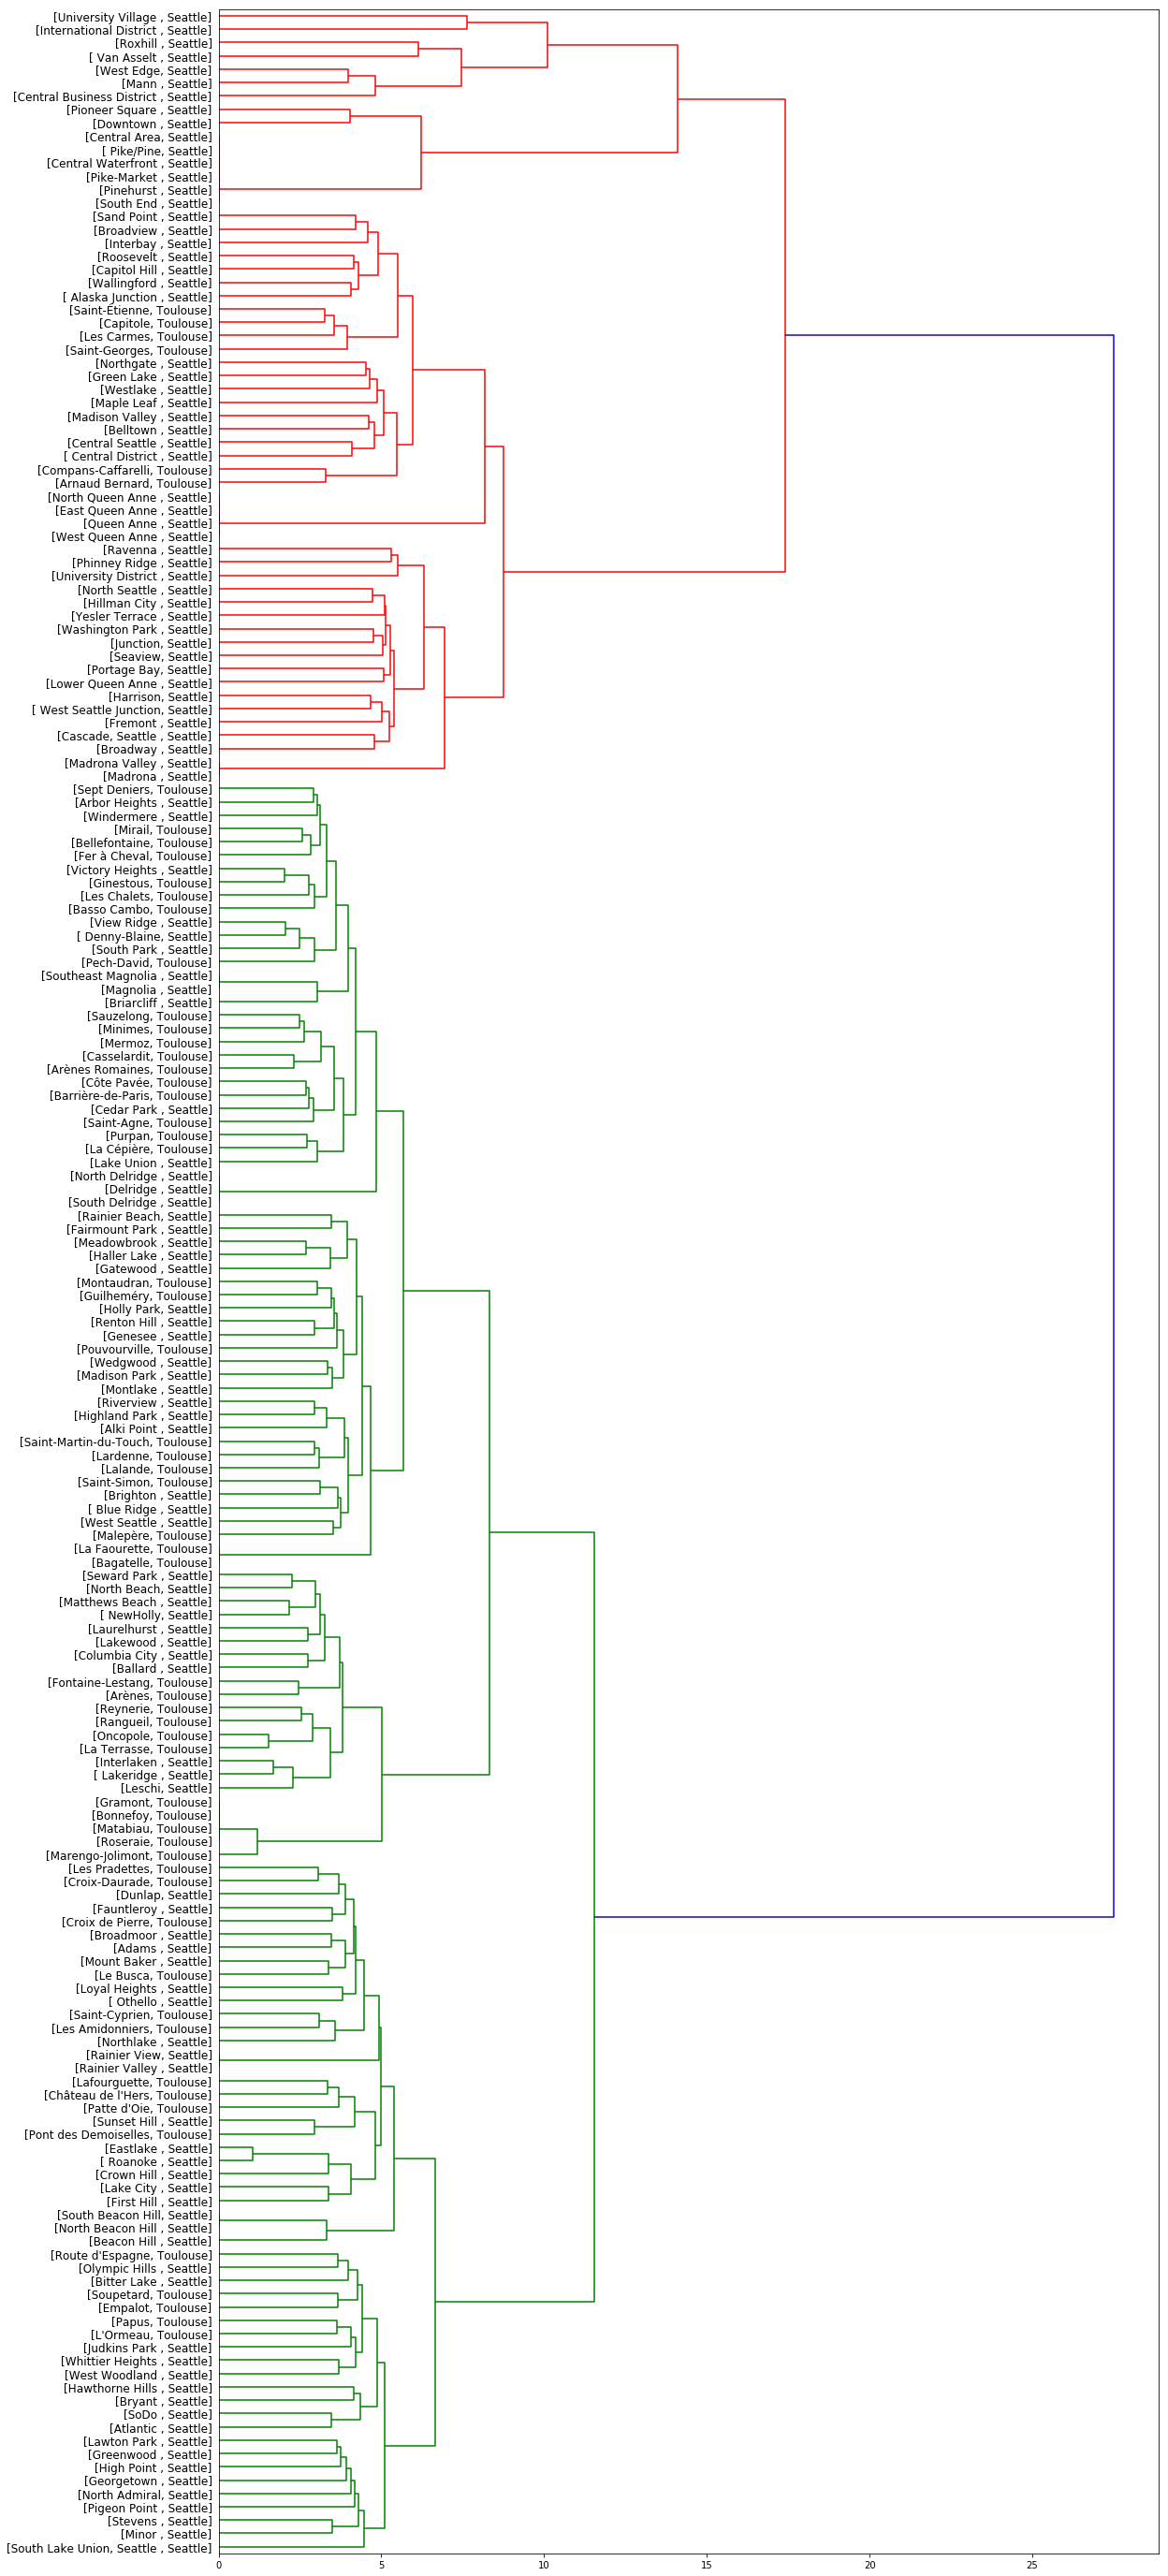

In [122]:
fig = pylab.figure(figsize=(18,50))
def llf(id):
    return '[%s]' % (seattle_and_toulouse_grouped['Neighborhood'][id] )
    
dendro = hierarchy.dendrogram(Z,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')